## 深層学習の実習

### 訓練データとテストデータそれぞれの画像ファイルを読み込む

#### `image_dataset_from_directory()` で読み込む

In [12]:
# 訓練データとテストデータの画像を読み込む
# （サイズは縦横224pxにリサイズする）
import tensorflow as tf

train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "nagaoka_gis/train",
    image_size=(224, 224),
    label_mode="binary",
    batch_size=32,
    shuffle=True
)

test_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "nagaoka_gis/test",
    image_size=(224, 224),
    label_mode="binary",
    batch_size=32,
    shuffle=False
)

Found 20 files belonging to 2 classes.
Found 6 files belonging to 2 classes.


#### データを確認する

In [13]:
# データの詳細を表示する
list(train_dataset.as_numpy_iterator())[0]

2025-08-07 17:22:08.059930: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


(array([[[[ 90.62245 , 123.62245 ,  80.301025],
          [ 87.477036, 120.477036,  77.15561 ],
          [117.94898 , 144.03317 ,  97.84439 ],
          ...,
          [ 49.77534 ,  75.77534 ,  50.77534 ],
          [ 71.731834,  93.87466 ,  70.72171 ],
          [ 37.068798,  59.354504,  36.925976]],
 
         [[ 89.5     , 121.98215 ,  80.01786 ],
          [ 92.875   , 125.35715 ,  83.39286 ],
          [ 95.87245 , 131.48979 ,  84.57908 ],
          ...,
          [ 56.650375,  82.650375,  57.650375],
          [ 54.33325 ,  78.476074,  52.87417 ],
          [ 65.36217 ,  89.64787 ,  63.47954 ]],
 
         [[ 95.359695, 127.359695,  88.359695],
          [ 81.04082 , 113.04082 ,  74.04082 ],
          [ 98.85204 , 129.26276 ,  87.45918 ],
          ...,
          [ 67.27591 ,  93.27591 ,  68.27591 ],
          [ 54.316437,  80.45926 ,  51.173615],
          [ 70.561295,  96.847   ,  67.27559 ]],
 
         ...,
 
         [[148.06638 , 156.37758 , 127.60718 ],
          [155.525

In [14]:
# 分類名（no／yes）をリストとして格納する
class_names = train_dataset.class_names
class_names

['no', 'yes']

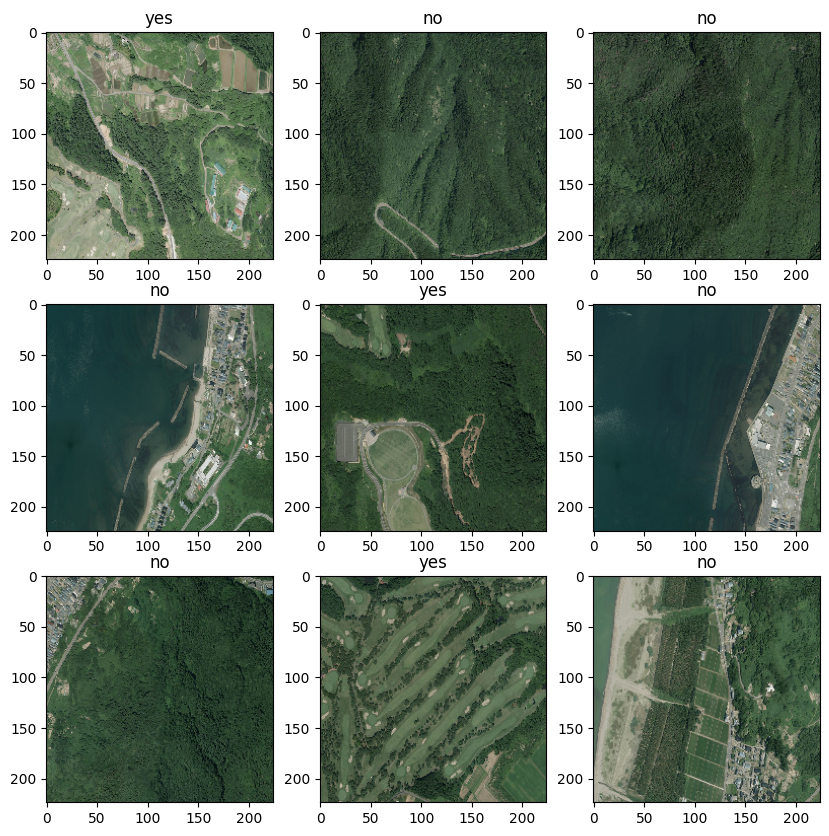

In [15]:
# 訓練データの一部を表示して確認
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))

for images, labels in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i].numpy().astype("uint8")[0]])

### データの水増しを行なう

In [16]:
# 画像の水増しをする関数の定義
def flip_left_right(image, label):   # 左右反転
    image = tf.image.flip_left_right(image)
    return image, label

def flip_up_down(image, label):      # 上下反転
    image = tf.image.flip_up_down(image)
    return image, label

def rot90(image, label):             # 反時計回りに90度回転
    image = tf.image.rot90(image)
    return image, label

def rot180(image, label):            # 反時計回りに180度回転
    image = tf.image.rot90(image, k=2)
    return image, label

def rot270(image, label):            # 反時計回りに270度回転
    image = tf.image.rot90(image, k=3)
    return image, label

In [17]:
# 画像の水増し処理の実行
train_dataset_lr     = train_dataset.map(flip_left_right)
train_dataset_ud     = train_dataset.map(flip_up_down)
train_dataset_rot90  = train_dataset.map(rot90)
train_dataset_rot180 = train_dataset.map(rot180)
train_dataset_rot270 = train_dataset.map(rot270)

In [18]:
# 水増ししたデータを訓練データに追加する
train_dataset = train_dataset.concatenate(train_dataset_lr)
train_dataset = train_dataset.concatenate(train_dataset_ud)
train_dataset = train_dataset.concatenate(train_dataset_rot90)
train_dataset = train_dataset.concatenate(train_dataset_rot180)
train_dataset = train_dataset.concatenate(train_dataset_rot270)

In [19]:
# データをシャッフルする
train_dataset = train_dataset.shuffle(32)

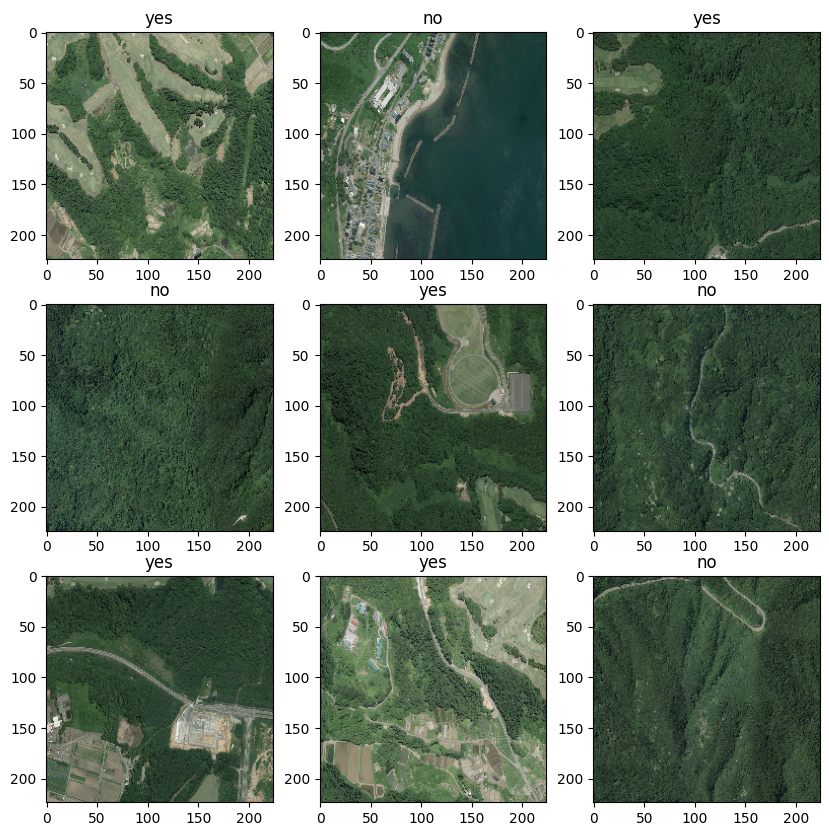

In [20]:
# 訓練データの一部を表示して確認
plt.figure(figsize=(10, 10))

for images, labels in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i].numpy().astype("uint8")[0]])

### モデルを作って学習する

#### MobileNetV2の学習済みモデルを読み込む

In [26]:
# MobileNetV2モデルを作成する
input_layer = tf.keras.Input(shape=(224, 224, 3))   # 入力層
l_layer = tf.keras.applications.mobilenet_v2.preprocess_input(input_layer)   # 前処理（正規化）をする層

weights_path = './17_task_review/mobilenet_v2_weights_tf_dim_ordering_tf_kernels_1.0_224_no_top.h5'
base_model = tf.keras.applications.mobilenet_v2.MobileNetV2(
    input_shape=(224, 224, 3),
    input_tensor=l_layer,
    include_top=False,
    weights=weights_path,
    pooling='avg'
)
base_model.trainable = False

#### 出力層を作成する

In [27]:
# Dense層を追加する
output_layer = tf.keras.layers.Dense(1, activation='sigmoid')

#### モデルを完成させる

In [28]:
# base_modelに先ほどのDense層を追加したモデルを作成する
model = tf.keras.Sequential([
    base_model,
    output_layer
])

In [29]:
# modelをcompileする
model.compile(optimizer="adam",
              loss='binary_crossentropy',
              metrics=["accuracy"])

In [30]:
# modelに学習させる
model.fit(train_dataset, epochs=20)

Epoch 1/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 70ms/step - accuracy: 0.6257 - loss: 0.6319
Epoch 2/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - accuracy: 0.8946 - loss: 0.3761
Epoch 3/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - accuracy: 0.9888 - loss: 0.2343
Epoch 4/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - accuracy: 1.0000 - loss: 0.1798
Epoch 5/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - accuracy: 1.0000 - loss: 0.1235
Epoch 6/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - accuracy: 1.0000 - loss: 0.0925
Epoch 7/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - accuracy: 1.0000 - loss: 0.0667
Epoch 8/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - accuracy: 1.0000 - loss: 0.0616
Epoch 9/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - accuracy: 1.0000 - loss: 0.0532
Epoch 10/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - accuracy: 1.0000 - loss: 0.0524
Epoch 11/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - accuracy: 1.0000 - loss: 0.0399
Epoch 12/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - accuracy: 1.0000 - loss: 0.0333
E

In [31]:
# テストデータで分類を実行する
pred_data = model.predict(test_dataset)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 356ms/step


In [32]:
# 分類した結果を確認する
pred_data

array([[0.13463433],
       [0.2538414 ],
       [0.13567382],
       [0.99670595],
       [0.7592017 ],
       [0.94356966]], dtype=float32)

In [33]:
# evaluate()でモデルの性能を評価する
model.evaluate(test_dataset)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 447ms/step - accuracy: 1.0000 - loss: 0.1533


[0.1533496379852295, 1.0]